# Classifying data

Pysal -module is an extensive Python library including various functions and tools to do spatial data analysis. It also includes all of the most common data classifiers that are used commonly e.g. when visualizing data.

In [13]:
import geopandas as gpd

fp = "C:\\Git\\CSC18\\data\\TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"

# Read the GeoJSON file similarly as Shapefile
acc = gpd.read_file(fp)

# Let's see what we have
acc.head(5)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,area,geometry
0,15981,36,15988,41,6002702,14698,65,73,14698,61,72,5975375,14456,207,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((391000.0001349226 6667750.00004299, ..."
1,16190,34,16197,39,6002701,14661,64,73,14661,60,72,5975375,14419,206,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((390750.0001349644 6668000.000042951,..."
2,15727,33,15733,37,6001132,14256,59,69,14256,55,62,5975375,14014,200,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((391000.0001349143 6668000.000042943,..."
3,15975,33,15982,37,6001131,14512,62,73,14512,58,70,5975375,14270,204,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((390750.0001349644 6668000.000042951,..."
4,16136,35,16143,40,6001138,14730,65,73,14730,61,72,5975375,14212,203,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((392500.0001346234 6668000.000042901,..."


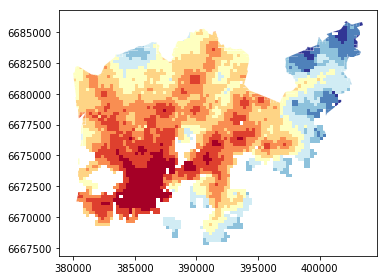

In [15]:
#Remove NoData values that are presented with value -1
acc = acc[acc['pt_r_tt'] >=0]

import matplotlib.pyplot as plt

# Plot using 9 classes and classify the values using "Fisher Jenks" classification
# Column pt_r_tt tells the time in minutes that it takes to reach city center from different parts of the city
acc.plot(column="pt_r_tt", scheme="Fisher_Jenks", k=9, cmap="RdYlBu", linewidth=0);
plt.tight_layout()

So from this figure we can see that the travel times are lower in the south where the city center is located but there are some areas of “good” accessibility also in some other areas (where the color is red).

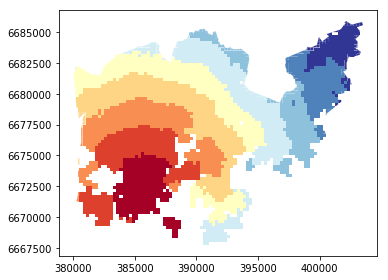

In [17]:
#Plot walking (near-Euclidean) distances
acc.plot(column="walk_d", scheme="Fisher_Jenks", k=9, cmap="RdYlBu", linewidth=0);

# Use tight layour
plt.tight_layout();

### Classify using pysal

In [18]:
import pysal as ps

# Define the number of classes
n_classes = 9

The classifier needs to be initialized first with make() function that takes the number of desired classes as input parameter.

In [20]:
# Create a Natural Breaks classifier
classifier = ps.Natural_Breaks.make(k=n_classes)

# Classify the data
classifications = acc[['pt_r_tt']].apply(classifier)

# Let's see what we have
classifications.head()

,pt_r_tt
0,7
1,7
2,6
3,7
4,7


In [21]:
# Rename the column so that we know that it was classified with natural breaks
classifications.columns = ['nb_pt_r_tt']

# Join with our original data (here index is the key)
acc = acc.join(classifications)

# Let's see how our data looks like
acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,...,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,area,geometry,nb_pt_r_tt
0,15981,36,15988,41,6002702,14698,65,73,14698,61,...,5975375,14456,207,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((391000.0001349226 6667750.00004299, ...",7
1,16190,34,16197,39,6002701,14661,64,73,14661,60,...,5975375,14419,206,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((390750.0001349644 6668000.000042951,...",7
2,15727,33,15733,37,6001132,14256,59,69,14256,55,...,5975375,14014,200,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((391000.0001349143 6668000.000042943,...",6
3,15975,33,15982,37,6001131,14512,62,73,14512,58,...,5975375,14270,204,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((390750.0001349644 6668000.000042951,...",7
4,16136,35,16143,40,6001138,14730,65,73,14730,61,...,5975375,14212,203,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((392500.0001346234 6668000.000042901,...",7


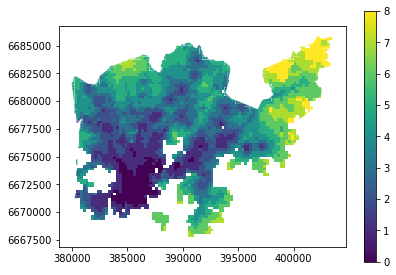

In [22]:
# Plot
acc.plot(column="nb_pt_r_tt", linewidth=0, legend=True);
plt.tight_layout()

### Multicriteria data classification

Let’s create a function where we classify the geometries into two classes based on a given threshold -parameter. If the area of a polygon is lower than the threshold value (average size of the lake), the output column will get a value 0, if it is larger, it will get a value 1.

First we need to create a function for our classification task. This function takes a single row of the GeoDataFrame as input, plus few other parameters that we can use.

In [24]:
def customClassifier2(row, src_col1, src_col2, threshold1, threshold2, output_col):
    # 1. If the value in src_col1 is LOWER than the threshold1 value
    # 2. AND the value in src_col2 is HIGHER than the threshold2 value, give value 1, otherwise give 0
    if row[src_col1] < threshold1 and row[src_col2] > threshold2:
        # Update the output column with value 0
        row[output_col] = 1
    # If area of input geometry is higher than the threshold value update with value 1
    else:
        row[output_col] = 0

    # Return the updated row
    return row

Let’s do our classification based on two criteria and find out grid cells where the travel time is lower or equal to 20 minutes but they are further away than 4 km (4000 meters) from city center.



In [25]:
#Create empty column
acc["Suitable_area"] = None

#Apply custom classifier
acc = acc.apply(customClassifier2, src_col1='pt_r_tt', src_col2='walk_d', threshold1=20, threshold2=4000, output_col="Suitable_area", axis=1)

acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,...,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,area,geometry,nb_pt_r_tt,Suitable_area
0,15981,36,15988,41,6002702,14698,65,73,14698,61,...,14456,207,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((391000.0001349226 6667750.00004299, ...",7,0
1,16190,34,16197,39,6002701,14661,64,73,14661,60,...,14419,206,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((390750.0001349644 6668000.000042951,...",7,0
2,15727,33,15733,37,6001132,14256,59,69,14256,55,...,14014,200,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((391000.0001349143 6668000.000042943,...",6,0
3,15975,33,15982,37,6001131,14512,62,73,14512,58,...,14270,204,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((390750.0001349644 6668000.000042951,...",7,0
4,16136,35,16143,40,6001138,14730,65,73,14730,61,...,14212,203,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((392500.0001346234 6668000.000042901,...",7,0


In [26]:
#How many Polygons are suitable?
acc['Suitable_area'].value_counts()

0    3808
1       9
Name: Suitable_area, dtype: int64

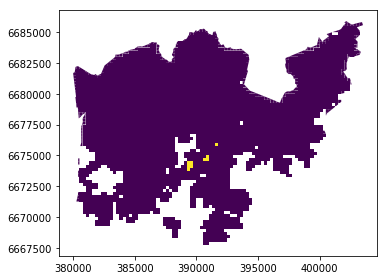

In [27]:
# Plot
acc.plot(column="Suitable_area", linewidth=0);
plt.tight_layout();